In [1]:
import logging
import os
import sys
import math
import argparse
sys.path.append('scripts')
sys.path.append('share')
sys.path.append('python')
from collections import namedtuple
import numpy as np
import pandas as pd
import h5py as h5
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import tensorflow
import tensorflow.keras as keras
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn

In [2]:
def doNumber(data_EC, data_Layer, data_number, data_true, data_estimated):

    data = {}

    outdata = np.zeros(
        (data_number.shape[0],),
        dtype=[
            ('Output_number', np.dtype(('f4', 3))),
            ('Output_number_true', 'i4'),
            ('Output_number_estimated', 'i4')
        ]
    )

    IBL = np.logical_and(data_Layer == 0, data_EC == 0)
    Barrel = np.logical_and(data_Layer > 0, data_EC == 0)
    Endcap = data_EC != 0

    outdata['Output_number'] = data_number
    outdata['Output_number_true'] = data_true
    outdata['Output_number_estimated'] = data_estimated

    '''
    thrs = [0.6, 0.2]
    outdata['Output_number_estimated'][
        np.where(np.logical_and(data_number[:,1] < thrs[0], data_number[:,2] < thrs[1]))
    ] = 1
    outdata['Output_number_estimated'][
        np.where(np.logical_and(data_number[:,1] >= thrs[0], data_number[:,2] < thrs[1]))
    ] = 2
    outdata['Output_number_estimated'][
        np.where(data_number[:,2] >= thrs[1])
    ] = 3
    '''

    data['IBL'] = outdata[IBL]
    data['Barrel'] = outdata[Barrel]
    data['Endcap'] = outdata[Endcap]
    return data

In [3]:
def evaluate(data, classes):
    pos, neg = classes

    pos_sel = data['Output_number_true'] == pos
    neg_sel = data['Output_number_true'] == neg

    isel = np.where(
        np.logical_or(
            pos_sel,
            neg_sel,
        )
    )[0]

    fpr, tpr, _ = roc_curve(
        data['Output_number_true'][isel],
        data['Output_number'][isel][:, pos - 1],
        pos_label=pos
    )
    auc1 = auc(fpr, tpr)

    return fpr, tpr, auc1

In [4]:
def plotRocs(fpr, tpr, auc1, labels, classes, outpath, title):
    pos, neg = classes
    plt.style.use('classic')

    for i, label in enumerate(labels):
        plt.plot(fpr[i], tpr[i], label=f'{label} (AUC = {auc1[i]:.2f})')
    
    rand_chance = np.linspace(0, 1, 100)
    plt.plot(rand_chance,rand_chance, ':', color='grey', label='Random (AUC = 0.5)')
    plt.semilogx()
    plt.ylabel(f"Pr(Estimated: {pos}-particle | True: {pos}-particle)")
    plt.xlabel(f"Pr(Estimated: {pos}-particle | True: {neg}-particle)")
    plt.xlim([0.001, 1.05])
    plt.ylim(0,1.5)
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.figtext(0.25, 0.90,f'{title} {pos} vs {neg}',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=10)
    plt.savefig(f'{outpath}{title}_{pos}vs{neg}_ROC.png')
    plt.close()


In [5]:
def rocGraph(datas, labels, outpath, classes):

    fpr = [None] * len(datas)
    tpr = [None] * len(datas)
    auc1 = [None] * len(datas)

    fprl = []
    tprl = []
    aucl = []

    for j, layer in enumerate(datas[0]):
        for i, data in enumerate(datas):
            fpr[i], tpr[i], auc1[i] = evaluate(data[layer], classes)
        fprl.append(fpr)
        tprl.append(tpr)
        aucl.append(auc1)
        
    for i, layer in enumerate(datas[0]):
        plotRocs(fprl[i], tprl[i], aucl[i], labels, classes, outpath, layer)


    for i, data in enumerate(datas):
        fpr[i], tpr[i], auc1[i] = evaluate(np.concatenate([data[x] for x in data]), classes)

    plotRocs(fpr, tpr, auc1, labels, classes, outpath, 'All')
        

In [6]:
def doRocs(datas, labels, outpath):
    rocGraph(datas, labels, outpath, (3, 2))
    rocGraph(datas, labels, outpath, (3, 1))
    rocGraph(datas, labels, outpath, (2, 3))
    rocGraph(datas, labels, outpath, (2, 1))
    rocGraph(datas, labels, outpath, (1, 2))
    rocGraph(datas, labels, outpath, (1, 3))

In [7]:
def plot_confusion_matrix(data, accuracy, labels, model, output_filename, layer):
    plt.style.use('seaborn')
    seaborn.set(color_codes=True)
    plt.figure(1, figsize=(9, 6))
 
    plt.title(f'Confusion Matrix for {model} {layer}', fontdict = {'fontsize' : 14})
 
    seaborn.set(font_scale=1.4)
    ax = seaborn.heatmap(data, vmin=0, vmax=1, annot=True, cmap="Greys", cbar_kws={'label': 'Cluster Density'})
 
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
 
    ax.set(ylabel="True Label", xlabel="Predicted Label")

    ax.text(1, 1, f'Accuracy = {accuracy:.2f}', size='12',
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes)
 
    plt.savefig(output_filename, bbox_inches='tight', dpi=300)
    plt.close()

In [8]:
def doMatrix(matrix):
    total = float(np.sum(matrix))
    correct = float(np.sum(np.diag(matrix)))
    accuracy = correct / total
    matrix = matrix / np.sum(matrix, axis=1, keepdims=True)
    return accuracy, matrix

def doConfusion(datas, labels, outpath):

    for i, data in enumerate(datas):

        for j, layer in enumerate(datas[0]):
            matrix = confusion_matrix(data[layer]['Output_number_true'], data[layer]['Output_number_estimated'], labels=[1,2,3])
            accuracy, matrix = doMatrix(matrix)
            plot_confusion_matrix(matrix, accuracy, ['1', '2', '3'], labels[i], f'{outpath}{labels[i]}_{layer}_confusion.png'.replace(" ", "_"), layer)

        matrix = confusion_matrix(np.concatenate([data[x] for x in data])['Output_number_true'], \
                    np.concatenate([data[x] for x in data])['Output_number_estimated'], labels=[1,2,3])
        accuracy, matrix = doMatrix(matrix)
        plot_confusion_matrix(matrix, accuracy, ['1', '2', '3'], labels[i], f'{outpath}{labels[i]}_total_confusion.png'.replace(" ", "_"), 'All Layers')
        

In [28]:
accuracy = 0

In [32]:
def doAccuracy(matrix):
    total = float(np.sum(matrix))
    correct = float(np.sum(np.diag(matrix)))
    accuracy = correct / total
    return accuracy

layer = 'Barrel'
thrs = [0.2, 0.4]
        
datas[0][layer]['Output_number_estimated'][
    np.where(np.logical_and(datas[0][layer]['Output_number'][:,1] < thrs[0], datas[0][layer]['Output_number'][:,2] < thrs[1]))
] = 1
datas[0][layer]['Output_number_estimated'][
    np.where(np.logical_and(datas[0][layer]['Output_number'][:,1] >= thrs[0], datas[0][layer]['Output_number'][:,2] < thrs[1]))
] = 2
datas[0][layer]['Output_number_estimated'][
    np.where(datas[0][layer]['Output_number'][:,2] >= thrs[1])
] = 3

layer = 'IBL'
thrs = [0.2, 0.4]
        
datas[0][layer]['Output_number_estimated'][
    np.where(np.logical_and(datas[0][layer]['Output_number'][:,1] < thrs[0], datas[0][layer]['Output_number'][:,2] < thrs[1]))
] = 1
datas[0][layer]['Output_number_estimated'][
    np.where(np.logical_and(datas[0][layer]['Output_number'][:,1] >= thrs[0], datas[0][layer]['Output_number'][:,2] < thrs[1]))
] = 2
datas[0][layer]['Output_number_estimated'][
    np.where(datas[0][layer]['Output_number'][:,2] >= thrs[1])
] = 3

layer = 'Endcap'
thrs = [0.2, 0.1]
        
datas[0][layer]['Output_number_estimated'][
    np.where(np.logical_and(datas[0][layer]['Output_number'][:,1] < thrs[0], datas[0][layer]['Output_number'][:,2] < thrs[1]))
] = 1
datas[0][layer]['Output_number_estimated'][
    np.where(np.logical_and(datas[0][layer]['Output_number'][:,1] >= thrs[0], datas[0][layer]['Output_number'][:,2] < thrs[1]))
] = 2
datas[0][layer]['Output_number_estimated'][
    np.where(datas[0][layer]['Output_number'][:,2] >= thrs[1])
] = 3
matrix = confusion_matrix(datas[0][layer]['Output_number_true'], datas[0][layer]['Output_number_estimated'], labels=[1,2,3])
tempAccuracy = doAccuracy(matrix)
if accuracy > tempAccuracy:
    print('worse')
    print(f'{tempAccuracy:4f} < {accuracy:4f}')
else:
    print('better')
    print(f'{tempAccuracy:4f} >= {accuracy:4f}')
    accuracy = tempAccuracy



better
0.816521 >= 0.000000


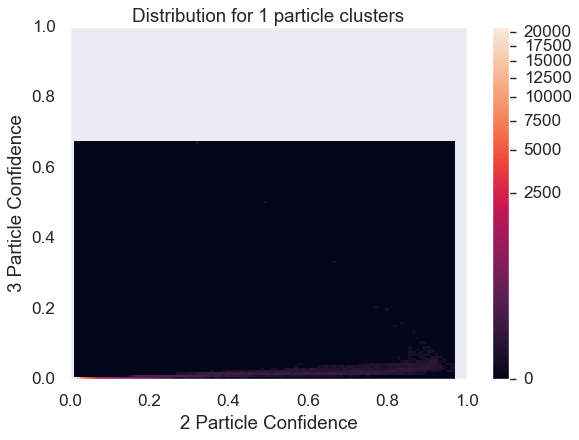

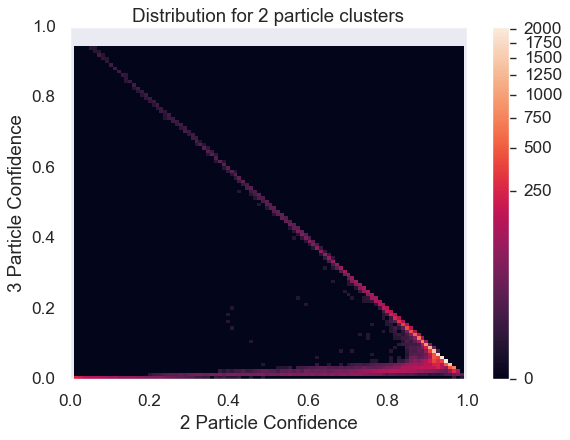

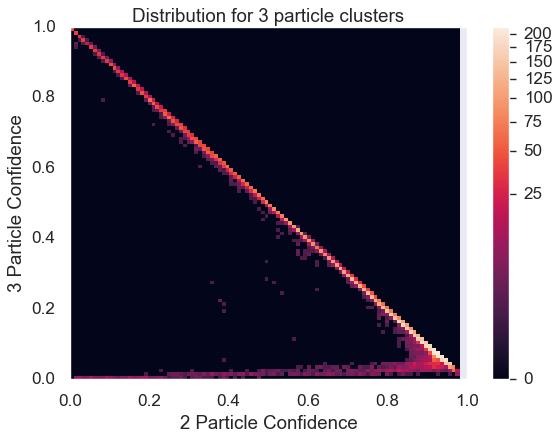

In [26]:
for i in range(1, 4):
    isel = np.where(datas[0]['Endcap']['Output_number_true'] == i)
    x = datas[0]['Endcap']['Output_number'][isel][:,1]
    y = datas[0]['Endcap']['Output_number'][isel][:,2]

    plt.hist2d(x, y, bins=(100,100), norm=mcolors.PowerNorm(0.3))
    plt.title(f'Distribution for {i} particle clusters')
    plt.xlabel('2 Particle Confidence')
    plt.ylabel('3 Particle Confidence')
    plt.xlim([0, 1])
    plt.ylim([0,1])
    cbar = plt.colorbar()
    cbar.set_label('')
    plt.show()
    plt.close()

## Load Data

In [27]:
datas = []
models = []
labels = []


#models.append("LG_applyjz7w")
#models.append("theano_kfold/theano_evensplit_kfold1")
#models.append("jz7wevensplit_applyjz7w")
#models.append("theano104_jz7wevensplit_applyjz4w")
#models.append('jz7wevensplitunshuffled_applyjz7w')
#models.append("jz7w_applyjz7w")
#models.append("apply_817tf")
#models.append("naturalsplit_applyjz7w")
#models.append("812_applyjz7w")
#models.append("814_applyjz7w")
#models.append("824_applyjz7w")
models.append("824_sigmoid_applyjz7w")
#models.append("824sigmoid_newstruct_applyjz7w")


#labels.append('LG Model')
#labels.append('even split on flipped jz7w')
#labels.append('even split shuffled on jz7w')
#labels.append('even split on unflipped jz4w')
#labels.append('even split unshuffled on jz7w')
#labels.append('natural split on jz7w theano')
#labels.append('natural split on jz7w tensorflow')
#labels.append("Natural Split")
#labels.append("Model 812")
#labels.append("Model 814")
#labels.append("Model 824")
labels.append("Model 829")
#labels.append("Model 831")


for model in models:
    with h5.File(f'output/newapply/{model}.h5', 'r') as data:
        data_EC = data['NN_barrelEC'][()]
        data_Layer = data['NN_layer'][()]
        data_number = data['Output_number'][()]
        data_true = data['Output_number_true'][()]
        data_estimated = data['Output_number_estimated'][()]

    datas.append(doNumber(data_EC, data_Layer, data_number, data_true, data_estimated))

'''
ECtrained = "endcap_flip_trained_apply"
Barreltrained = "barrel_trained_apply"
IBLtrained = "ibl_trained_apply"

with h5.File(f'output/{ECtrained}.h5', 'r') as data:
    data_EC = data['NN_barrelEC'][()]
    data_Layer = data['NN_layer'][()]
    data_number = data['Output_number'][()]
    data_true = data['Output_number_true'][()]

dataEC = doNumber(data_EC, data_Layer, data_number, data_true)

with h5.File(f'output/{Barreltrained}.h5', 'r') as data:
    data_EC = data['NN_barrelEC'][()]
    data_Layer = data['NN_layer'][()]
    data_number = data['Output_number'][()]
    data_true = data['Output_number_true'][()]

dataBarrel = doNumber(data_EC, data_Layer, data_number, data_true)

with h5.File(f'output/{IBLtrained}.h5', 'r') as data:
    data_EC = data['NN_barrelEC'][()]
    data_Layer = data['NN_layer'][()]
    data_number = data['Output_number'][()]
    data_true = data['Output_number_true'][()]

dataIBL = doNumber(data_EC, data_Layer, data_number, data_true)

datas.append({'IBL':dataIBL['IBL'], 'Barrel':dataBarrel['Barrel'], 'Endcap':dataEC['Endcap']})
'''

print('Done Loading')

Done Loading


## Make ROC Curves

In [15]:
outpath = "output/final/newarchitecture/"
doRocs(datas, labels, outpath)


## Make Confusion Matricies

In [33]:
outpath = "output/final/"
doConfusion(datas, labels, outpath)